# Spoken language and speaker gender identification
Download the dataset from https://www.kaggle.com/toponowicz/spoken-language-identification

In [1]:
import os

from time import perf_counter
import numpy as np

import soundfile as sf
from collections import Counter
import matplotlib.pyplot as plt

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
import keras
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dense, Flatten, Activation, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.callbacks import History, EarlyStopping, LearningRateScheduler
history = History()

#data_normalized=False
generator_init = False
model_saved = False
checkpoint_saved = False
SAVED_MODEL_PATH = './'
MODEL_NAME = SAVED_MODEL_PATH+'langid_model'
CHECKPOINT_FILEPATH = MODEL_NAME+'_CP'

# constants: choices among multiple NNs
USE_OVERFITTING_ORIGINAL_NW = 1
USE_DROPOUT_NO_REGULARIZATION_NW = 2
USE_DROPOUT_REGULARIZATION_NW = 3

nn_choice = USE_DROPOUT_REGULARIZATION_NW

WAVELET = 'db38'
"""
train_path = '../input/spoken-language-identification/train/train/'
test_path = '../input/spoken-language-identification/test/test/'
"""

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14303631497577933631
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10097114113101969225
physical_device_desc: "device: XLA_CPU device"
]


"\ntrain_path = '../input/spoken-language-identification/train/train/'\ntest_path = '../input/spoken-language-identification/test/test/'\n"

Download the dataset from https://www.kaggle.com/toponowicz/spoken-language-identification

In [2]:
# Data generator for serving up batches for training the NN
# ref https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
from keras.utils import Sequence
import pywt
import pdb
class langidDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, wavelet='db38', drop_levels=None,
                 batch_size=32, n_channels=1, n_classes=6, shuffle=True):
        'Initialization'
        self.wvlt = wavelet
        self.drop_lvls = slice(0,-drop_levels)
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
        # determine dimensions of input
        #import pdb; pdb.set_trace()
        X,y=self.__data_generation(self.list_IDs[:2])
        #pdb.set_trace()

        X = np.expand_dims(X,2)
        self.dim = X.shape[1:]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        X = tf.expand_dims(X,2)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = tf.range(len(self.list_IDs))
        if self.shuffle == True:
            tf.random.shuffle(self.indexes)

    def wavelet_features(self, list_IDs_temp):
        features = []
        y=[]
        # Take the DWT of each component and concat them end-to-end
        for ID in list_IDs_temp:
            # Store sample
            signal,fs = sf.read(ID)
            list_coeff = pywt.wavedec(signal, self.wvlt, mode='per')
            # string the coefficient arrays end-end to keep like ones together
            dwt_local_coeff=[]
            end_flag=0
            for coeff in list_coeff[self.drop_lvls]:
                dwt_local_coeff.extend(coeff)
            features.append(dwt_local_coeff)
            y.append(self.labels[ID])

        X = tf.convert_to_tensor(features)
        #pdb.set_trace()

        return X,y

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X,y = self.wavelet_features(list_IDs_temp)
        #pdb.set_trace()

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

../datasets/langid/train/de_f_404792fda5c66b95903adafd5a5f5d10.fragment20.pitch2.flac


Text(0.5, 0, 'Time [sec]')

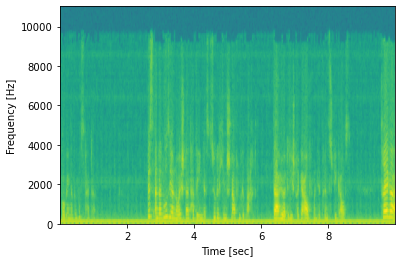

In [4]:
DATA_FOLDER = '../datasets/langid/'
train_path = DATA_FOLDER+'train/'
test_path = DATA_FOLDER+'test/'

#para train path
train_labels = []
for filename in os.listdir(train_path):
    train_labels.append(filename[:4]) # [:4] file naming convention, f.e. es_f
test_labels = []
for filename in os.listdir(test_path):
    test_labels.append(filename[:4])

# Create numeric labels
lb=0
labeld={}
for k in Counter(train_labels).keys():
    labeld[k] = lb
    lb=lb +1
# number of classes
num_classes = lb

# Create list of training/test filenames and dict {filename : label}
train_files = []
train_labels2={}
for filename in os.listdir(train_path):
    train_files.append(train_path+filename)
    train_labels2[train_path+filename] = labeld[filename[:4]]
test_files = []
test_labels2={}
for filename in os.listdir(test_path):
    test_files.append(test_path+filename)
    test_labels2[test_path+filename] = labeld[filename[:4]]

In [39]:
pywt.wavelist(kind='discrete')

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

Sampling frequency will be twice Nyquist, fs = 22050, so fn = 11025. Lets assume most audible features essential for the classification task are contained within 6 kHz, which is about a quarter of the sampling frequency. Hence we will retain all but the first two levels of detail coefficients from the DWT decomposition of the signal. We will compute the rest of the levels as doing so would bring out the details in those low frequency subbands, something that the classifier can benefit from.

<ipython-input-41-9a2cf4104c55>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20,10))
<ipython-input-41-9a2cf4104c55>:38: RuntimeWarning: divide by zero encountered in log10
  plt.plot(log10(abs(dwt(sig,w))))


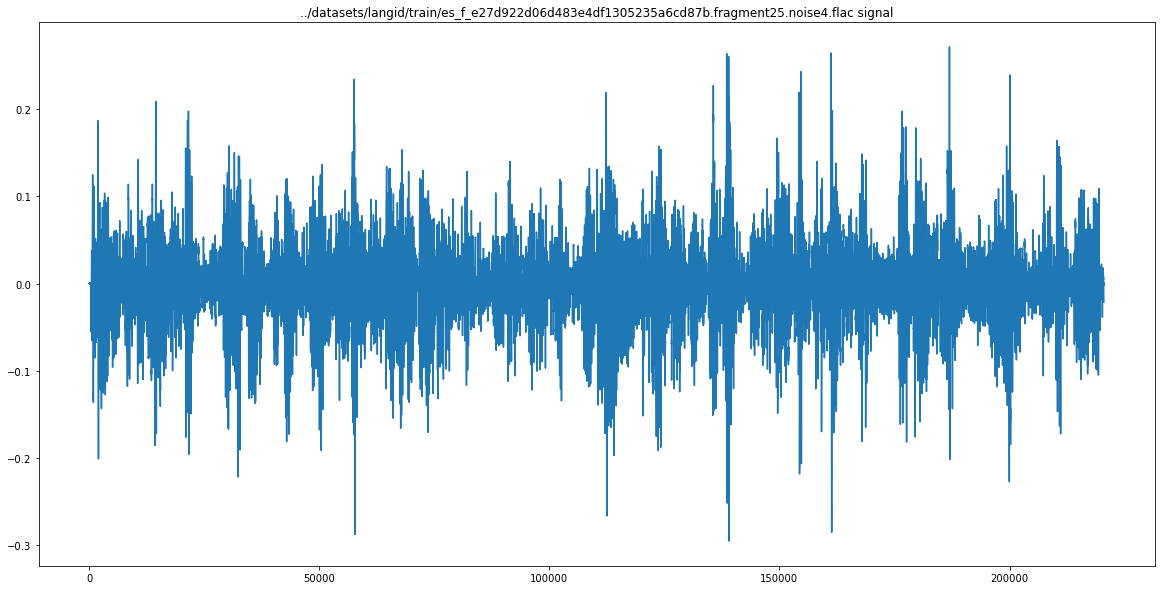

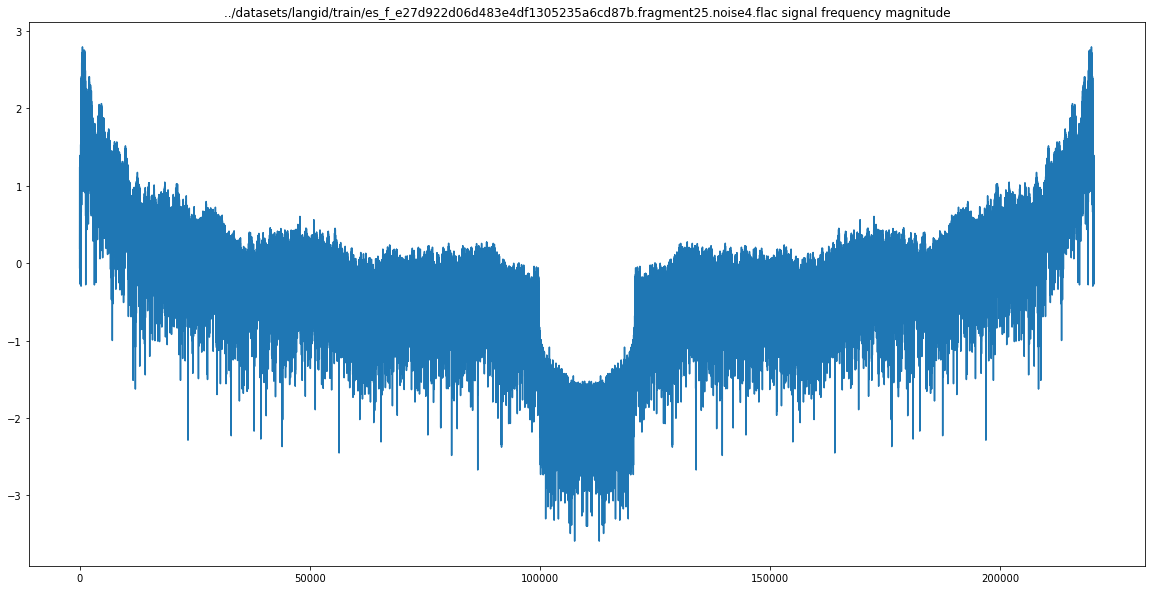

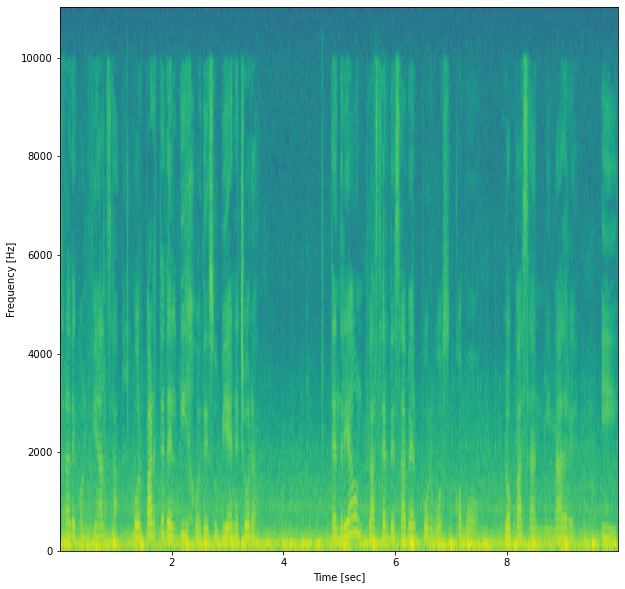

<Figure size 1440x720 with 0 Axes>

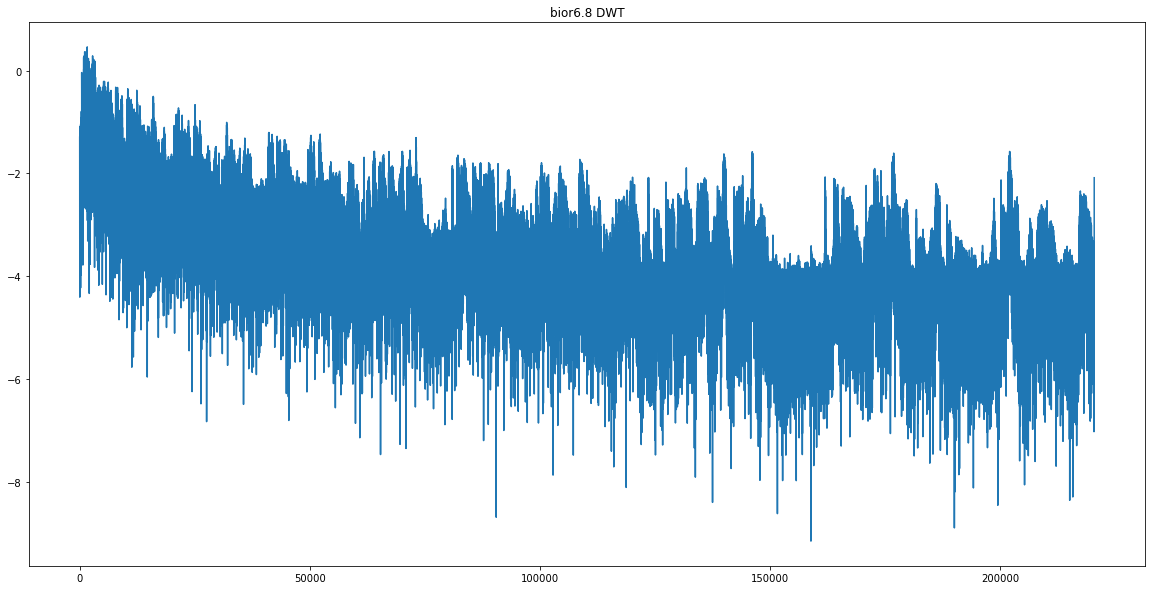

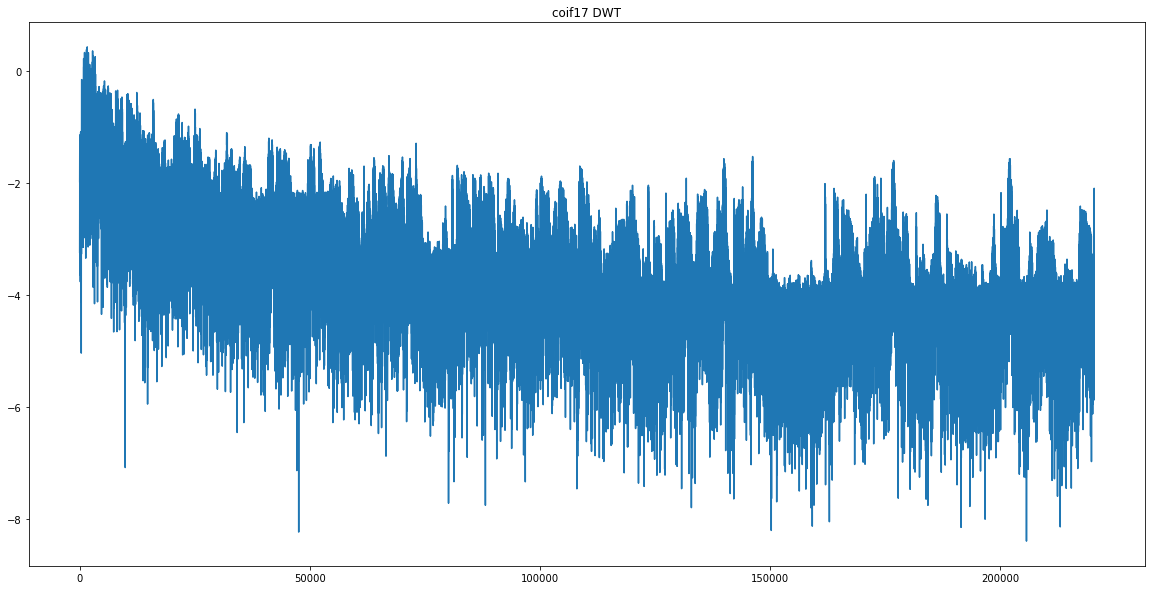

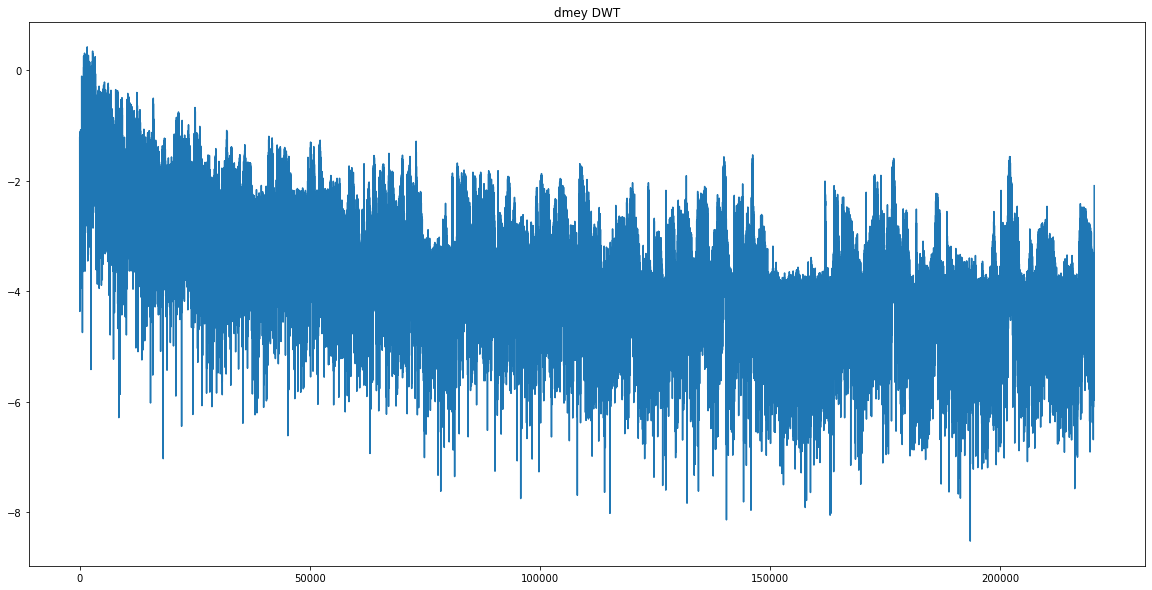

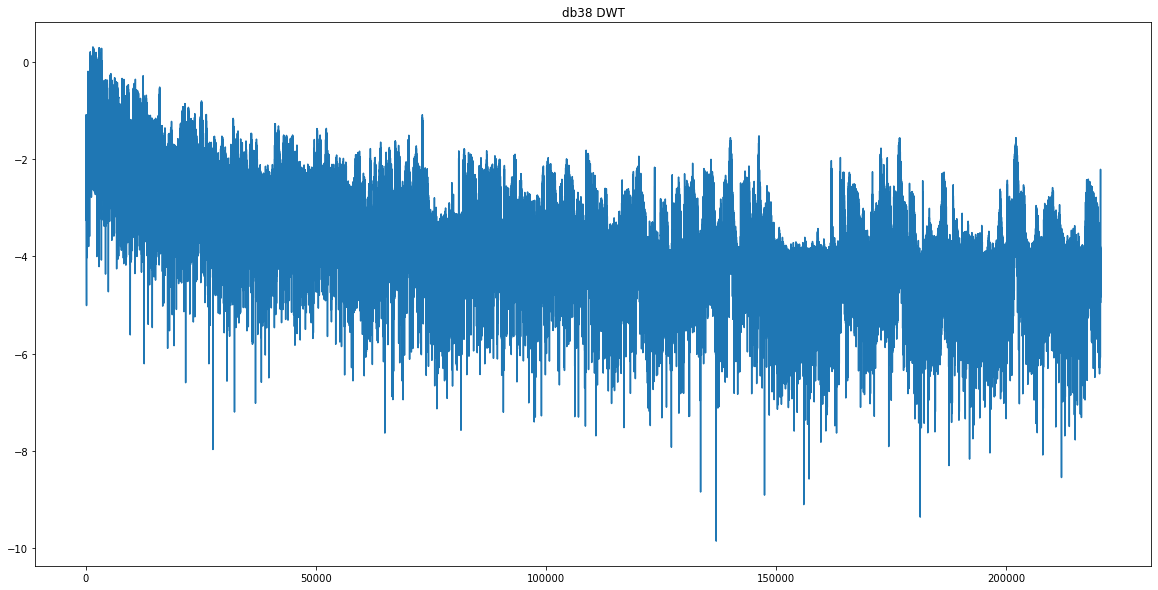

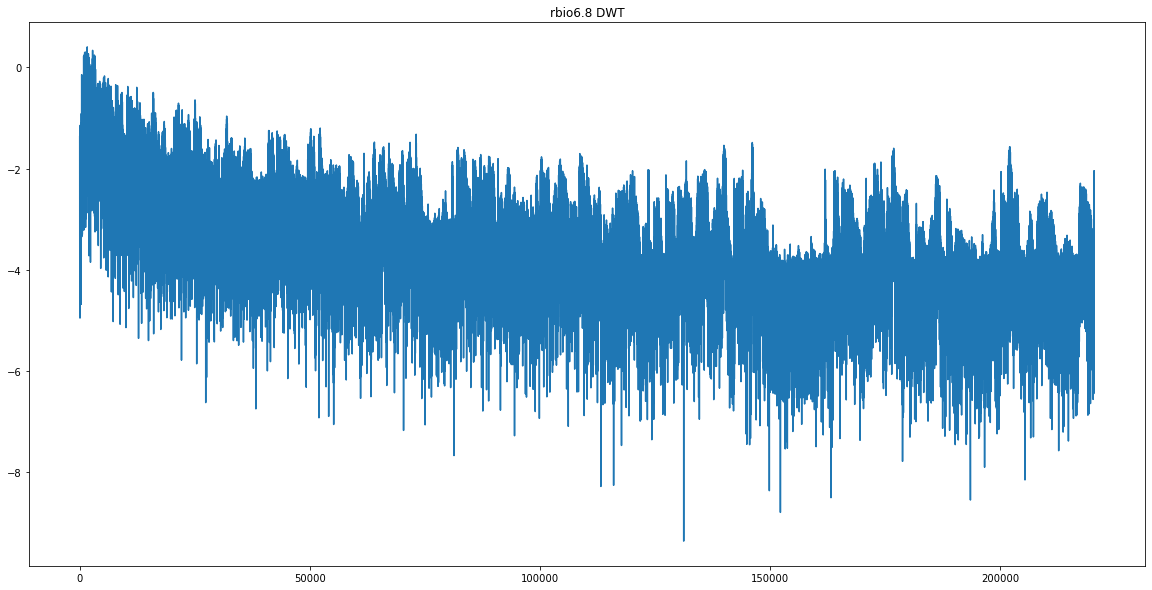

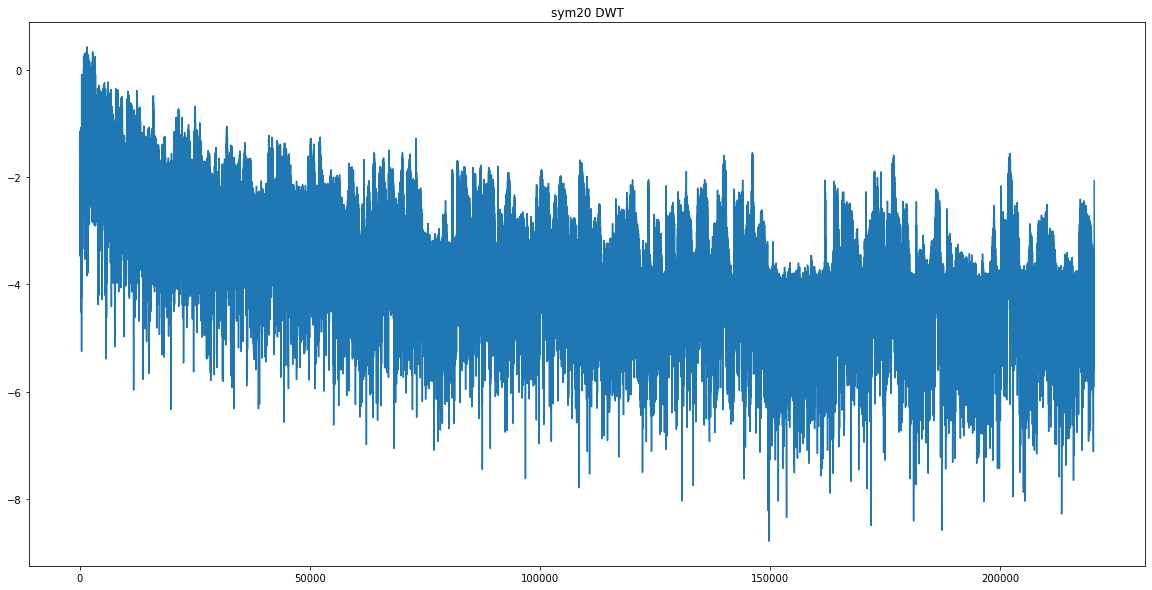

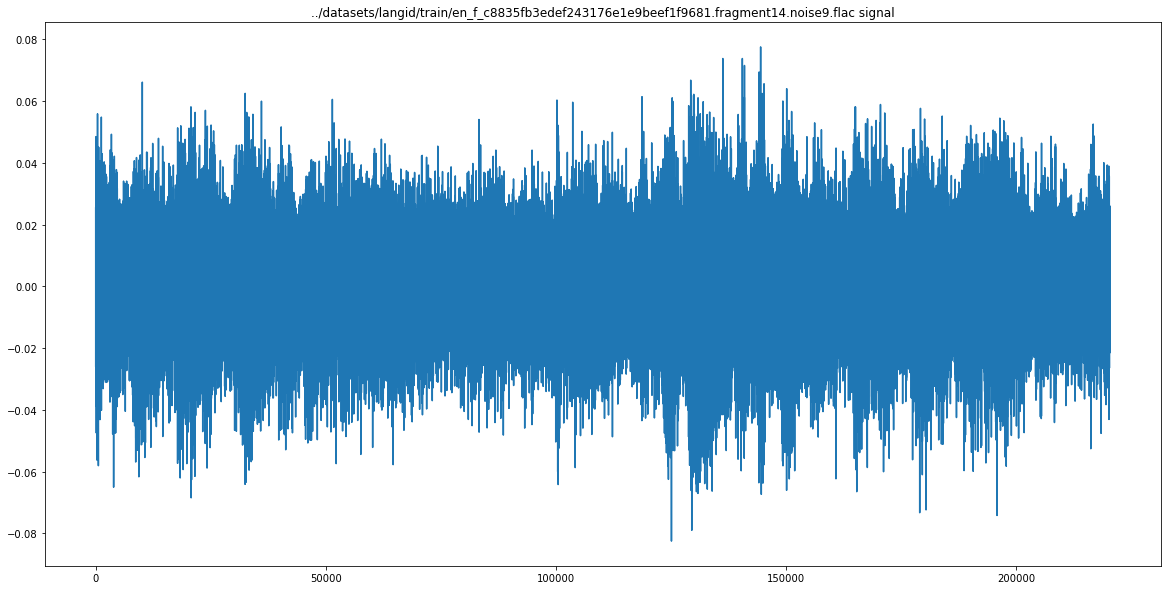

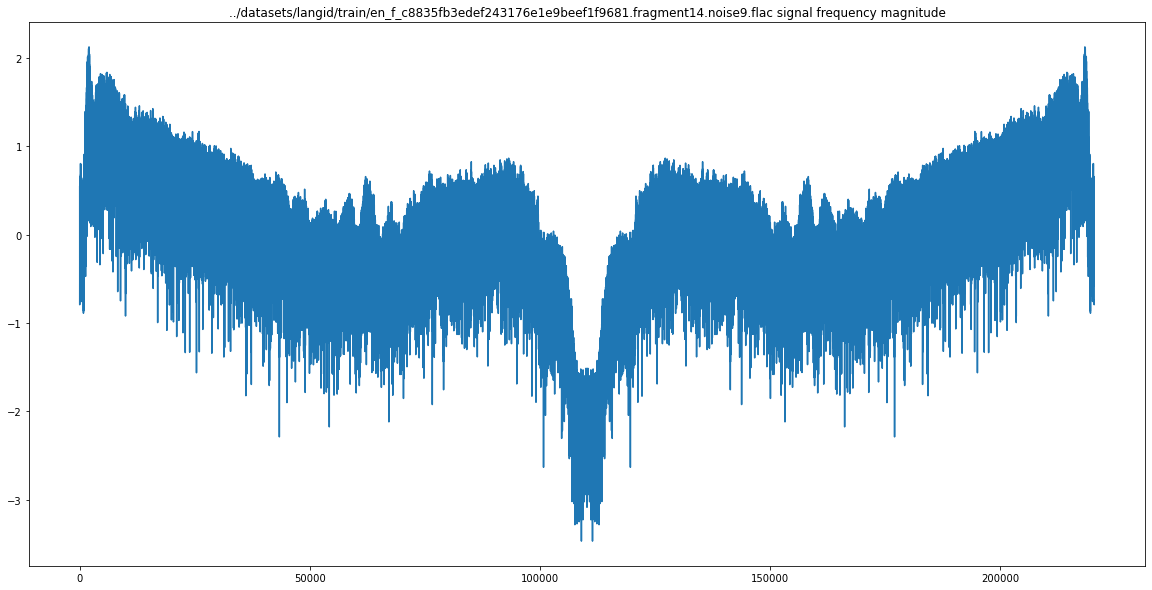

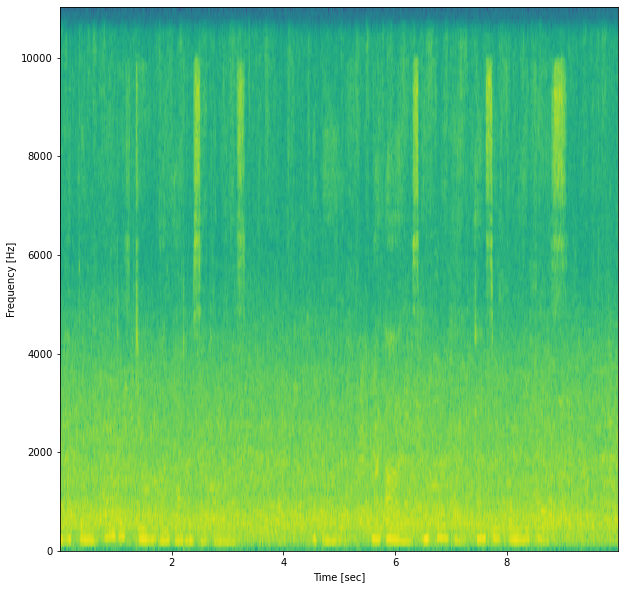

<Figure size 1440x720 with 0 Axes>

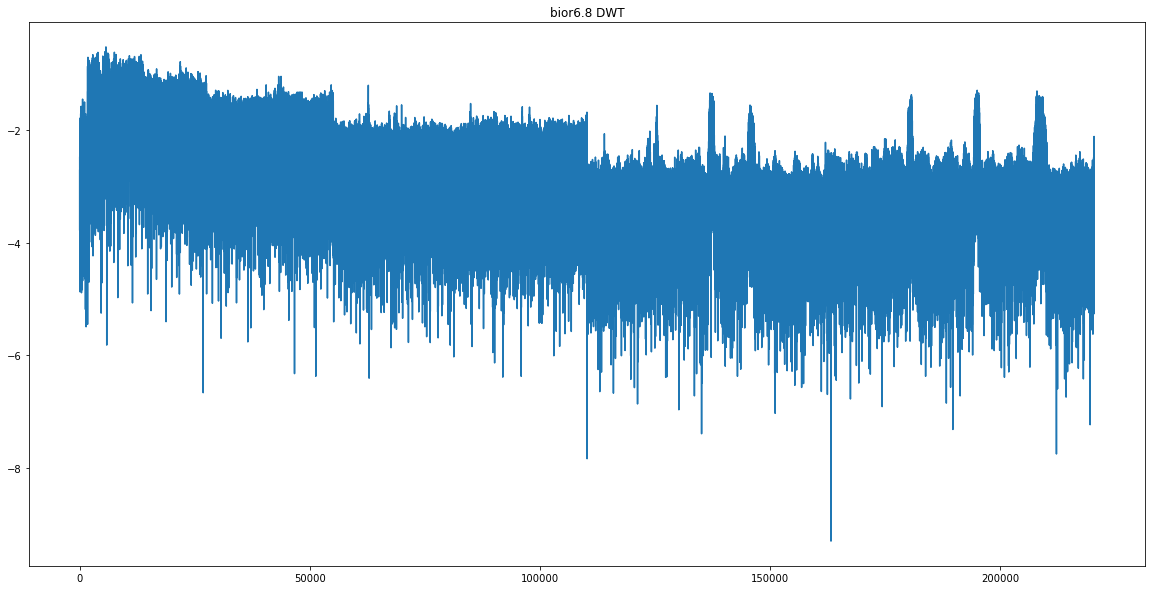

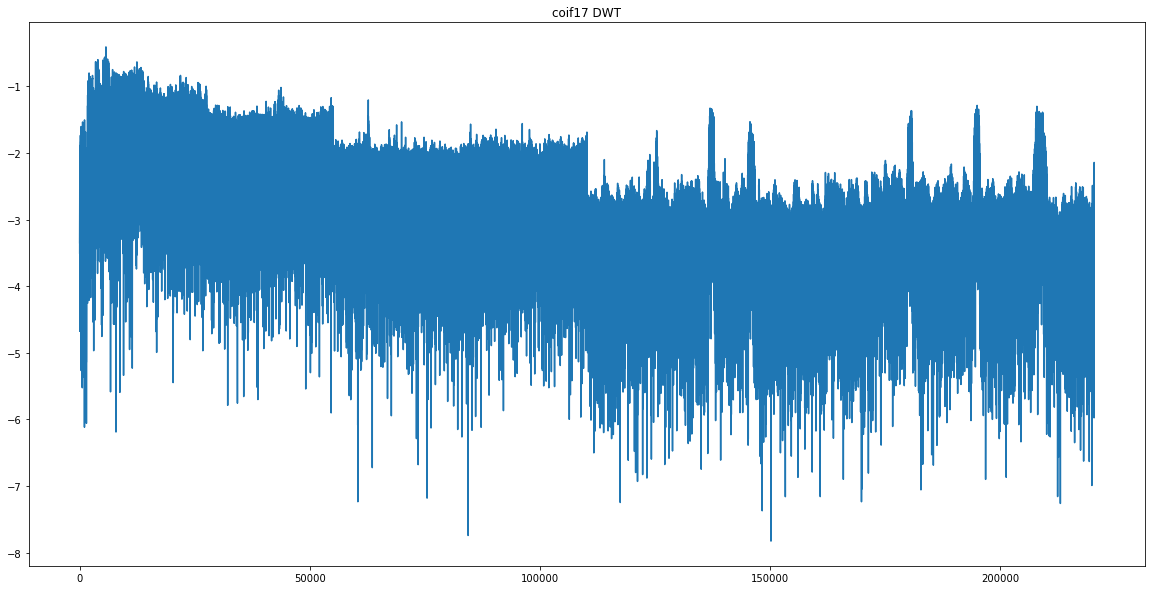

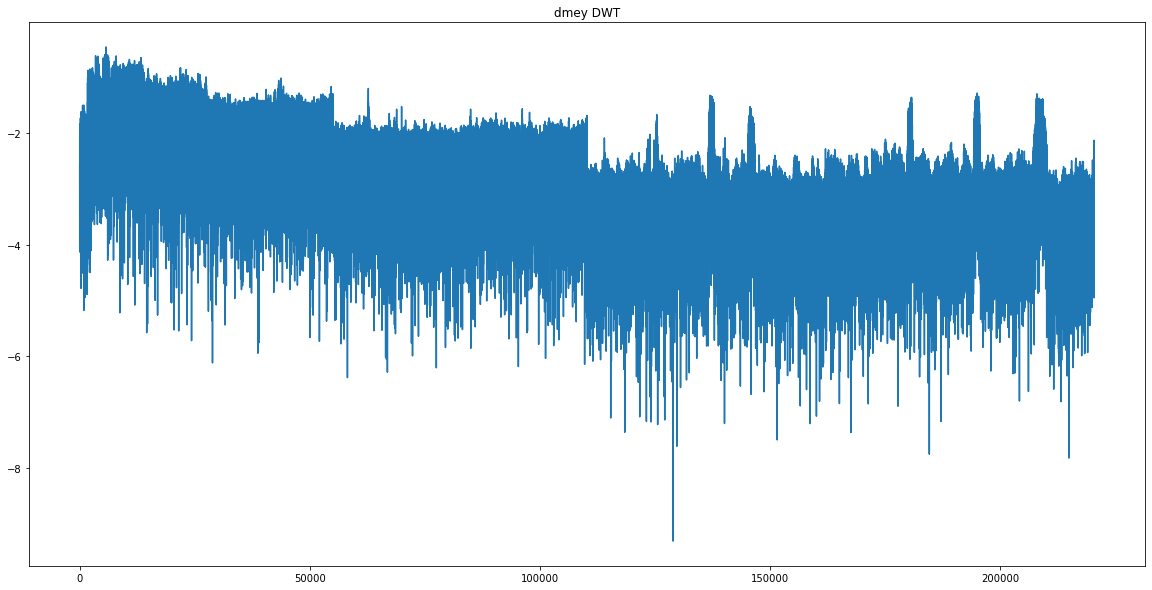

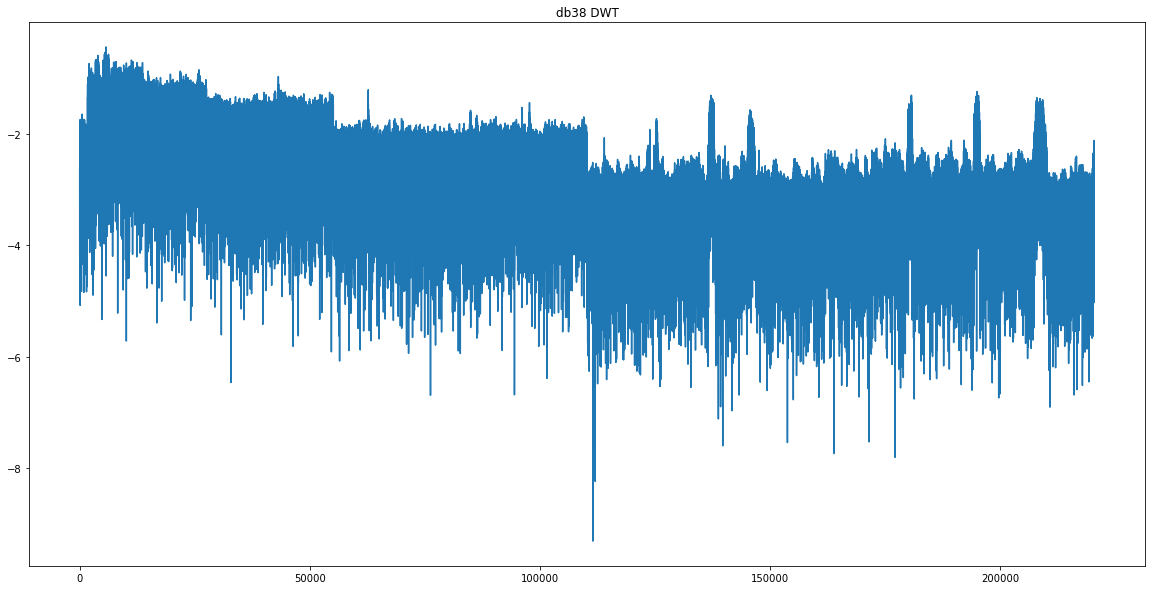

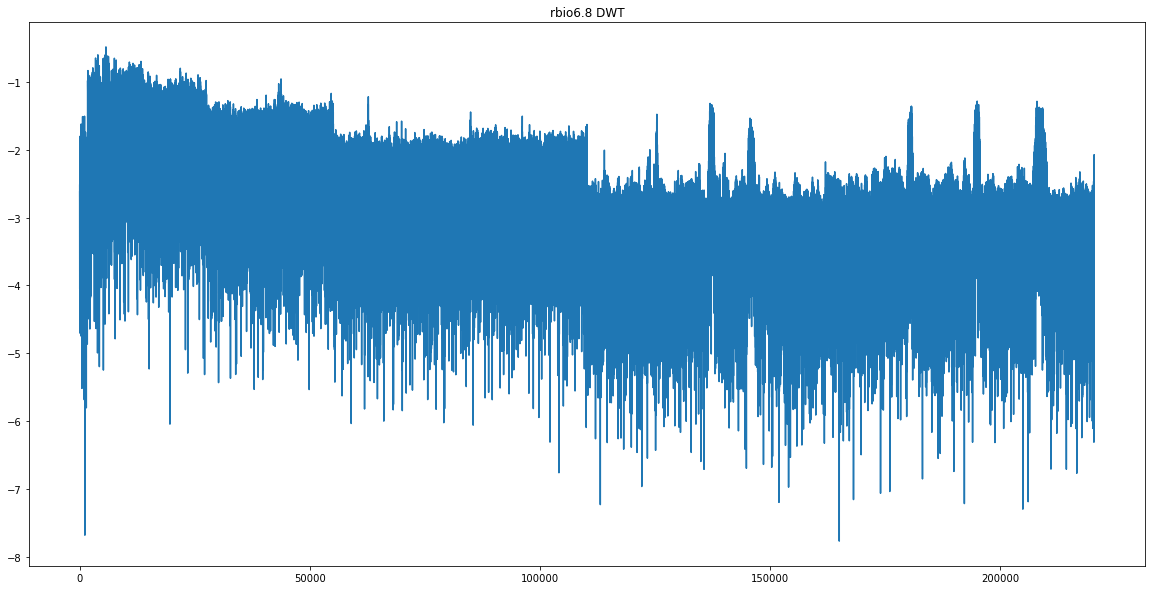

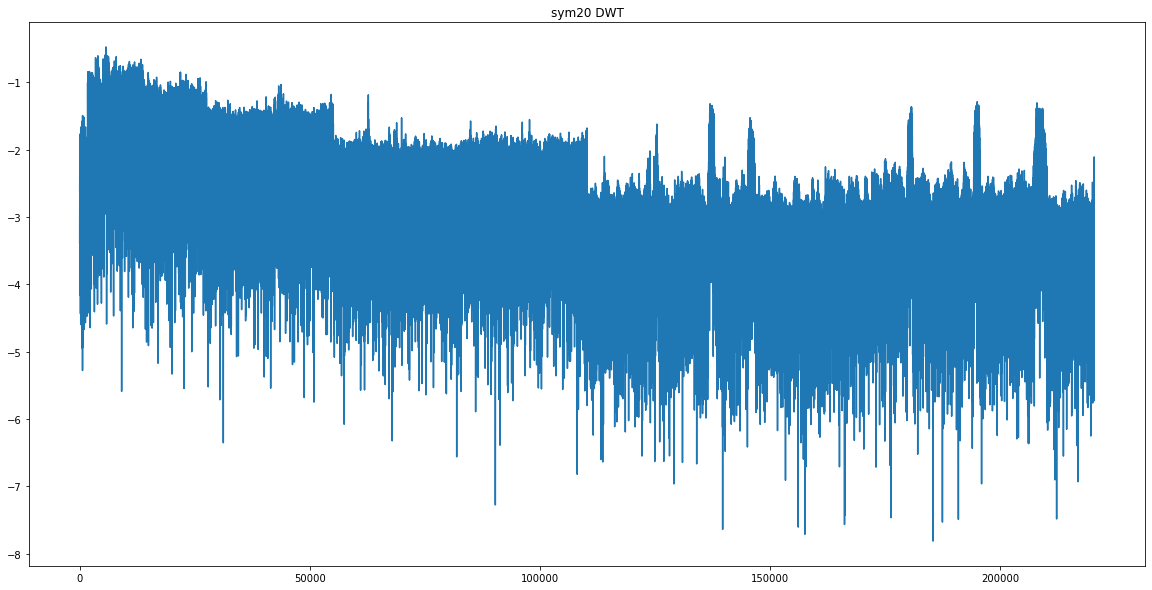

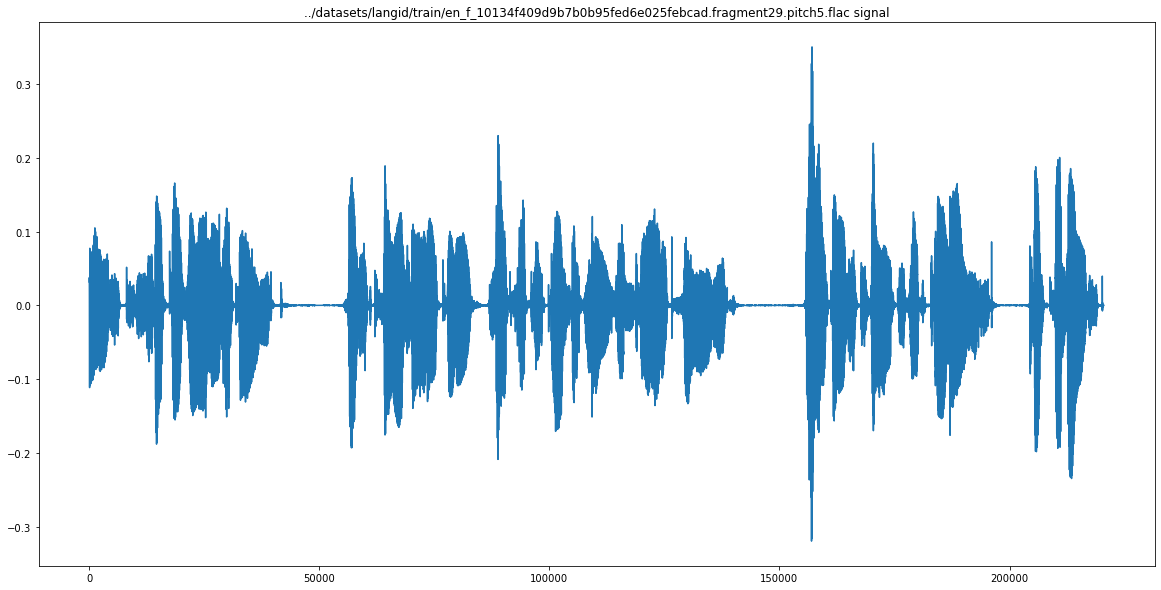

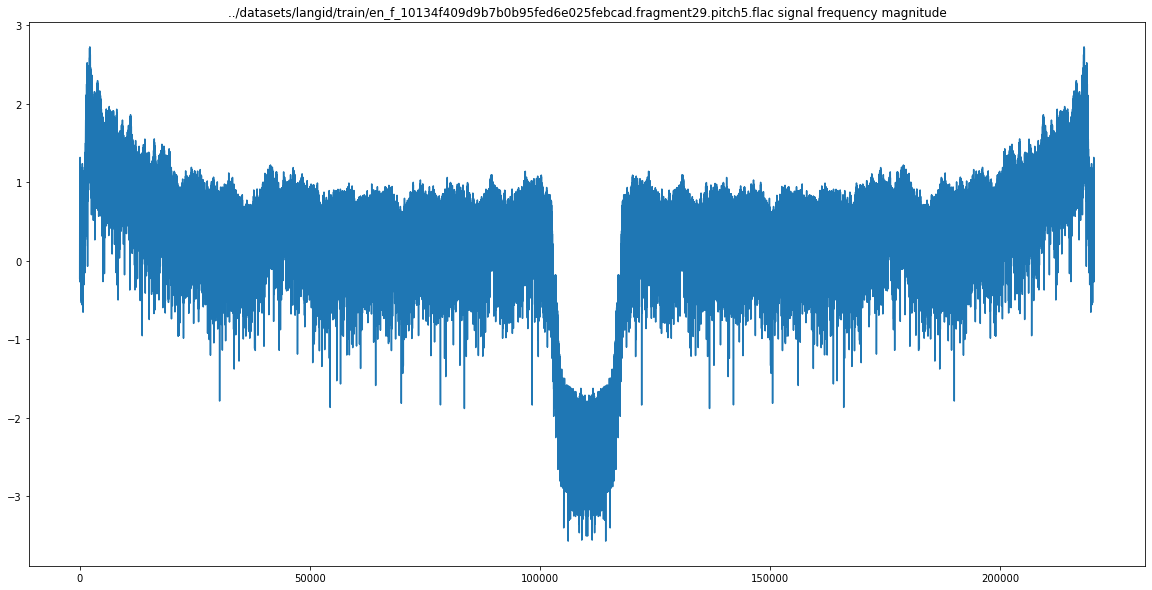

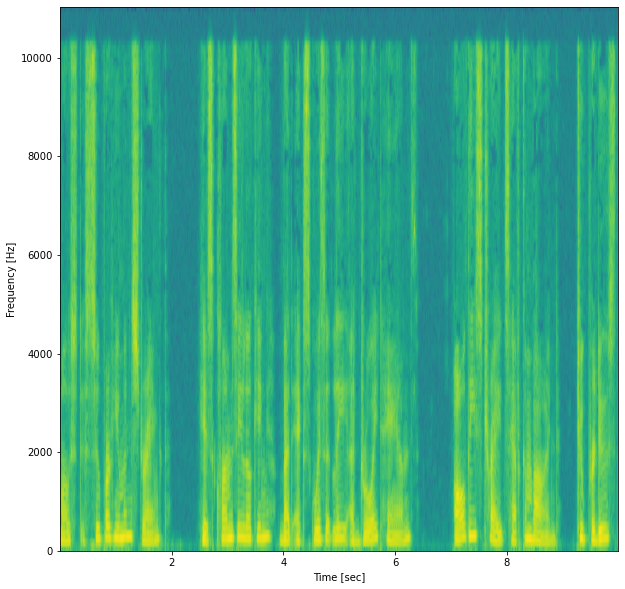

<Figure size 1440x720 with 0 Axes>

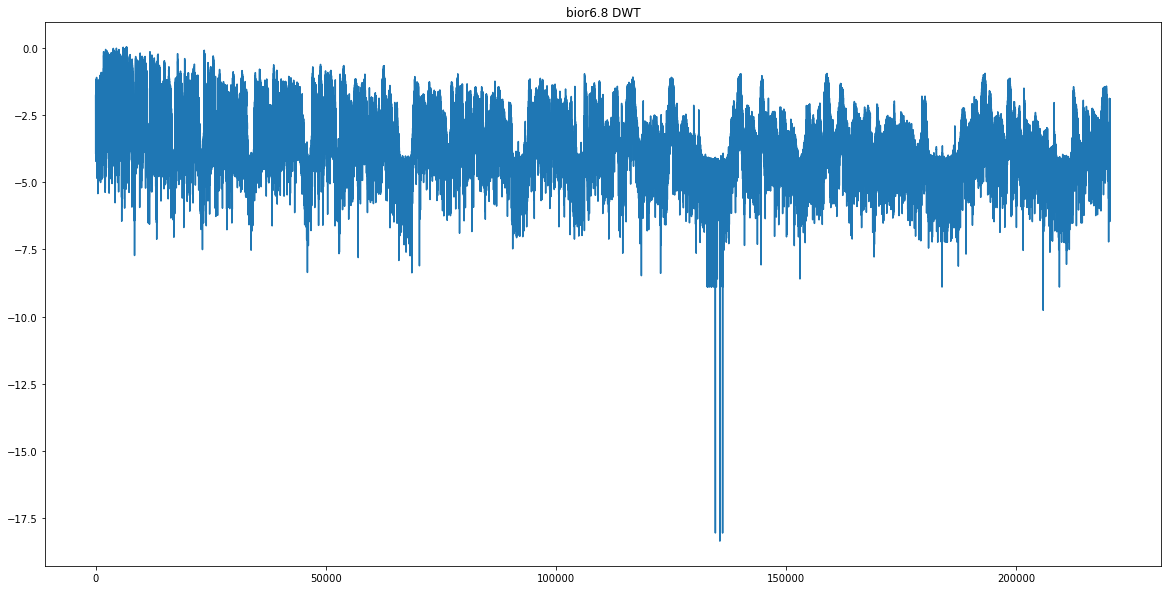

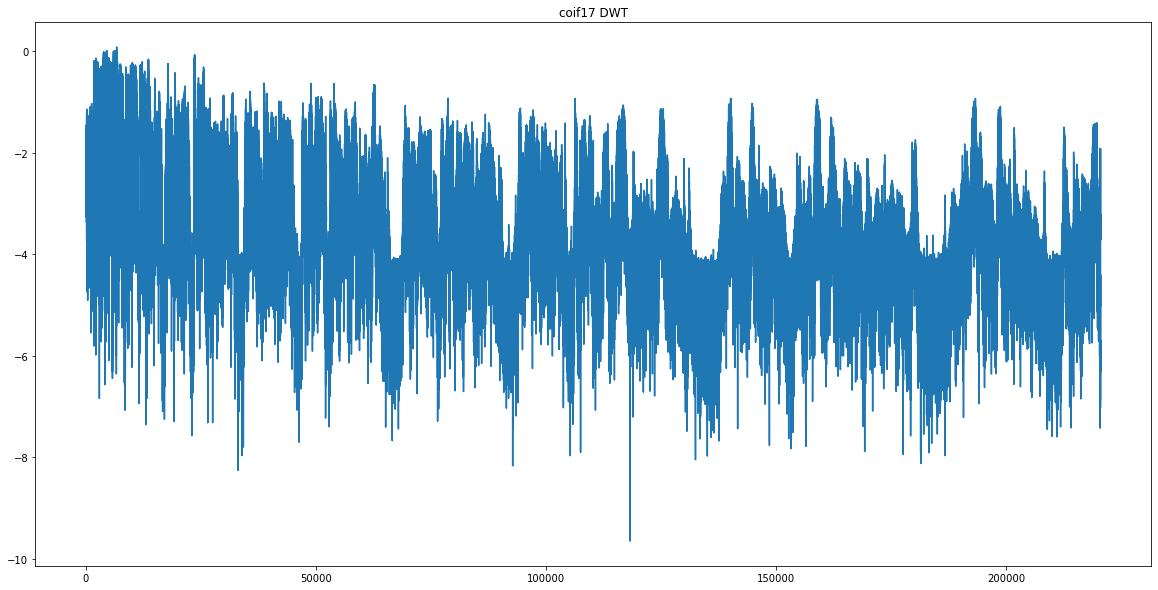

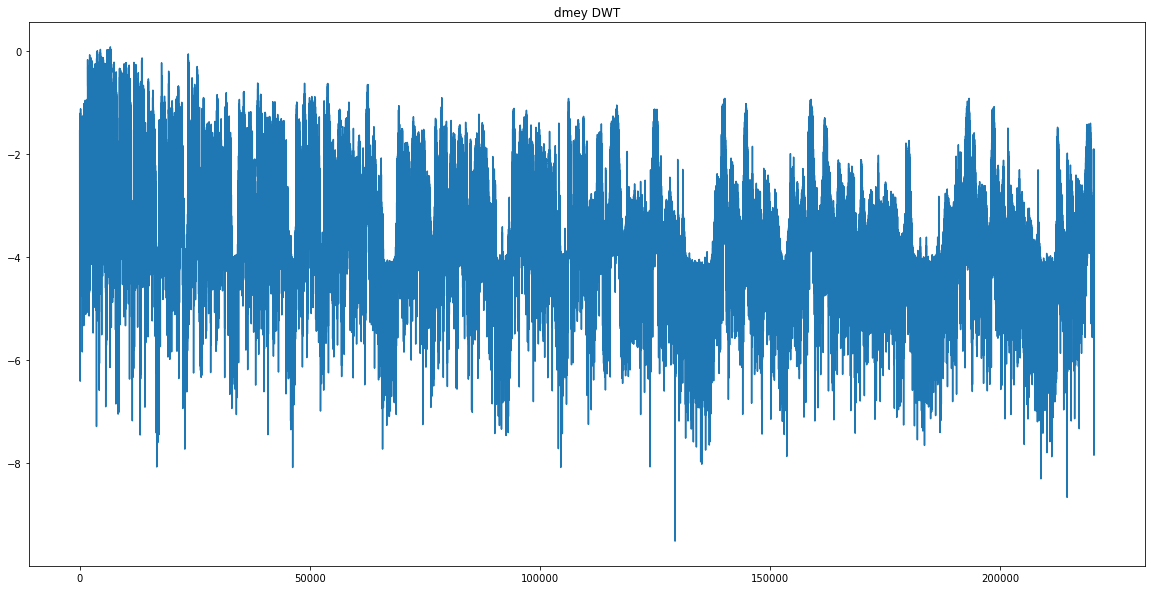

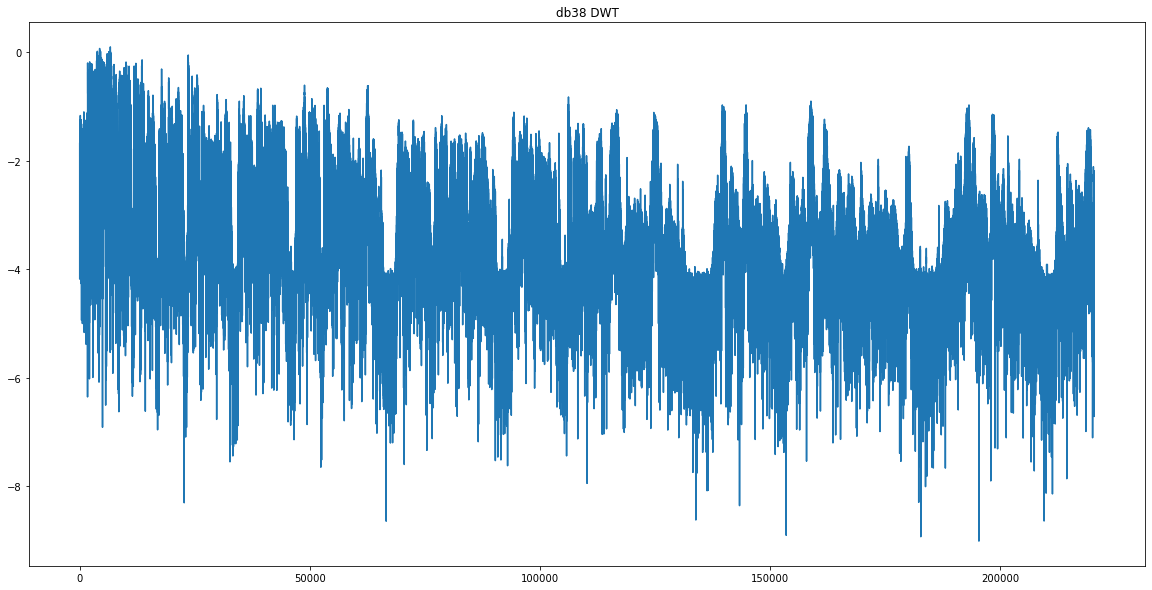

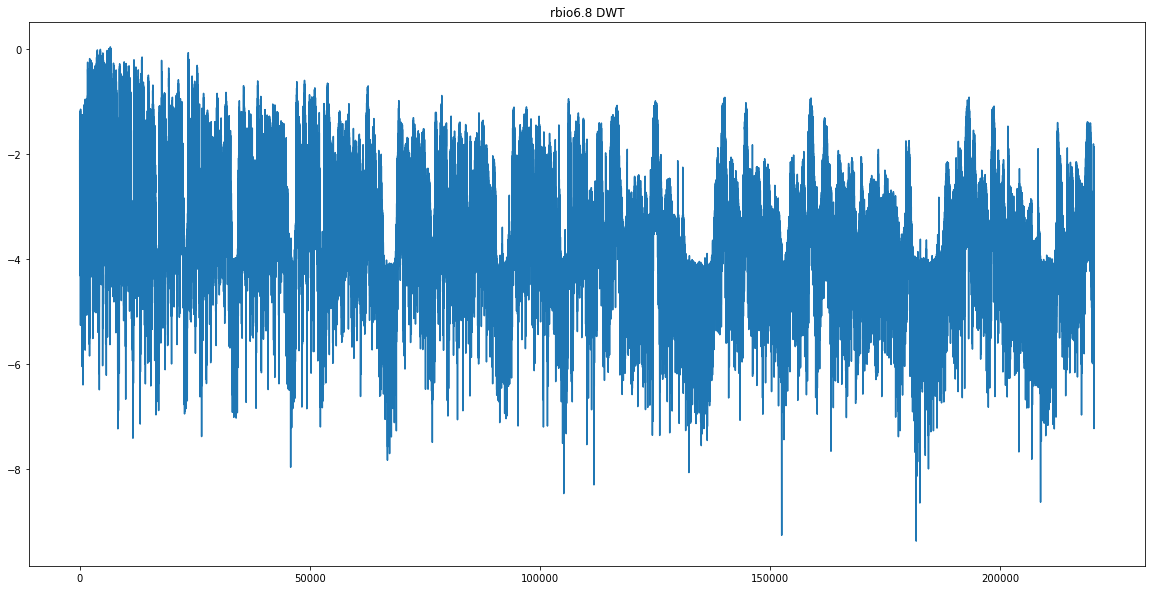

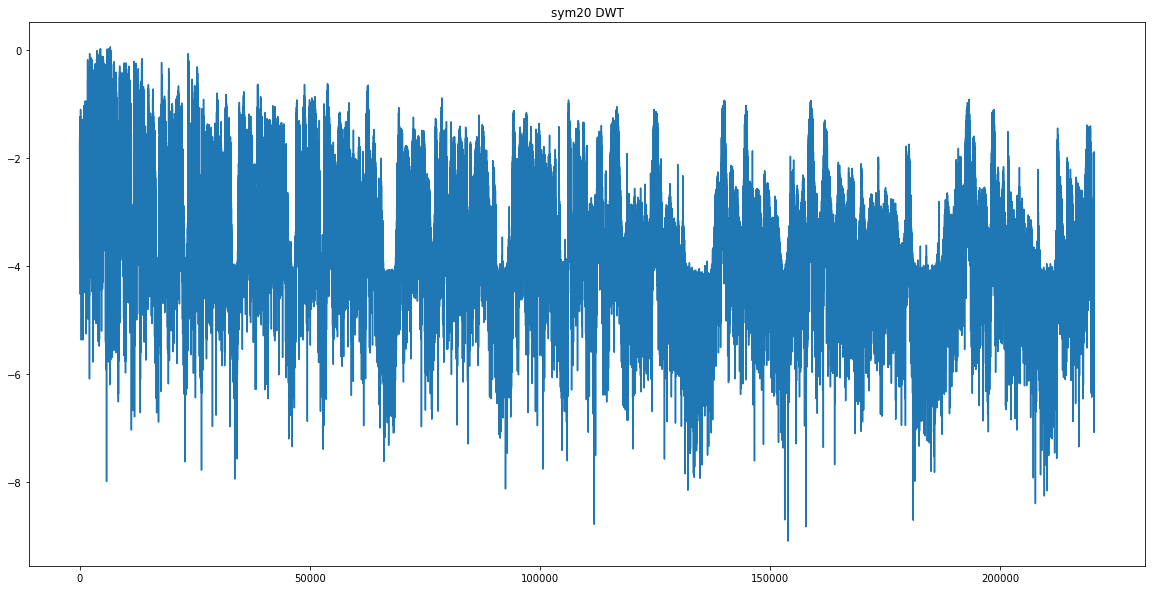

In [41]:
from numpy import log10, absolute as abs
from scipy.fftpack import dct,fft

def dwt (signal, waveletname, mode='per'):
    list_coeff = pywt.wavedec(signal, waveletname, mode)
    # convert the wavelet decomposition to array
    comp_dwt=[]
    for coeff in list_coeff:
        comp_dwt.extend(coeff)
    return comp_dwt

# Randomly choose 10 signals from the training set
sample_set = np.random.randint(len(train_files),size=3)
plt_wvts=['bior6.8','coif17','dmey','db38','rbio6.8','sym20']

for i in sample_set:
    f = train_files[i]
    sig,fs = sf.read(f)

    ## Now we plot
    plt.figure(figsize=(20,10))
    plt.plot(sig)
    plt.title('{} signal'.format(f))

    plt.figure(figsize=(20,10))
    plt.plot(log10(abs(fft(sig))))
    plt.title('{} signal frequency magnitude'.format(f))

    plt.figure(figsize=(10,10))
    plt.specgram(sig, Fs=fs)
    # add axis labels
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')

    plt.figure(figsize=(20,10))
    for w in plt_wvts:
        plt.figure(figsize=(20,10))
        plt.plot(log10(abs(dwt(sig,w))))
        plt.title('{} DWT'.format(w))


Strangely, the pyWavelets wavedec function, when specifying the number of levels to decompose, decomposes the signal to that many levels, instead of the more useful and efficient approach which would be to not decompose the first $x$ levels. We are therefore going to get the full decomposition and discard the first $x$ levels.

In [23]:
f = [train_files[i] for i in sample_set]
f

['../datasets/langid/train/de_m_ce41a51416f32ba7bb772887de8e0ebf.fragment18.noise5.flac',
 '../datasets/langid/train/en_m_d630900a88e2681c9d5d1026d7025d67.fragment8.noise7.flac',
 '../datasets/langid/train/de_f_5d2e7f30d69f2d1d86fd05f3bbe120c2.fragment8.noise1.flac']

In [ ]:
drop_levels = 2

In [4]:
import math

class CustomEarlyStopping(keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        self.best_weights = None
        
    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best_v_loss = np.Inf
        self.best_v_accuracy = 0

    def on_epoch_end(self, epoch, logs=None): 
        v_loss=logs.get('val_loss')
        v_acc=logs.get('val_accuracy')

        # If BOTH the val_loss AND val_accuracy do not improve for 'patience' epochs, 
        # stop training early.
        if np.less(v_loss, self.best_v_loss) or np.greater(v_acc, self.best_v_accuracy):
            self.best_v_loss = v_loss
            self.best_v_accuracy = v_acc
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
                
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

def step_decay(epoch):
    # 00158 = 90.4%
    initial_lrate = 0.00158
    drop = 0.9
    epochs_drop = 1
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [5]:
def dropout_block(model, no_nodes, dropout, reg=None, activation="relu"):
    model.add(Dense(units=no_nodes, kernel_regularizer=reg))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dropout(dropout))

epochs = 128
no_train=16000
no_test=None

# Parameters
params = {'wavelet' : WAVELET,
          'drop_levels' : drop_levels,
          'batch_size' : 64,
          'n_classes' : 6,
          'n_channels' : 1,
          'shuffle' : True}

if not generator_init:
    # Generators
    training_generator = langidDataGenerator(train_files[:no_train], train_labels2, **params)
    validation_generator = langidDataGenerator(test_files[:no_test], test_labels2, **params)
"""
if not data_normalized:
    training_generator.normalize_data()
"""

if not model_saved:
    model = Sequential()
    model.add(BatchNormalization(input_shape=training_generator.dim))
    model.add(Dropout(.2))
    model.add(Conv1D(32, kernel_size=9, strides=3))
    model.add(MaxPooling1D(3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(16, kernel_size=5, strides=2))
    model.add(MaxPooling1D(3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(8, kernel_size=3))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D(4, kernel_size=3))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    if nn_choice == USE_OVERFITTING_ORIGINAL_NW:
        model.add(Dense(1024, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(256, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-4,l2=5e-4)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(64, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(16, kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5,l2=1e-5)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(num_classes, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5),\
                        activation='softmax'))
    elif nn_choice == USE_DROPOUT_REGULARIZATION_NW:
        dropout_block(model, no_nodes=2**13, dropout=.3, reg=keras.regularizers.l1_l2(l1=1e-4,l2=1e-4))

        dropout_block(model, no_nodes=2**12, dropout=.3, reg=keras.regularizers.l1_l2(l1=1e-4,l2=1e-4))

        dropout_block(model, no_nodes=2048, dropout=.3, reg=keras.regularizers.l1_l2(l1=1e-4,l2=1e-4))
        dropout_block(model, no_nodes=1536, dropout=.2, reg=keras.regularizers.l1_l2(l1=1e-4,l2=1e-4))
        dropout_block(model, no_nodes=1024, dropout=.2, reg=keras.regularizers.l1_l2(l1=1e-4,l2=1e-4))
        dropout_block(model, no_nodes=784, dropout=.2, reg=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5))
        dropout_block(model, no_nodes=512, dropout=.2, reg=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5))
        dropout_block(model, no_nodes=256, dropout=.15, reg=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5))
        dropout_block(model, no_nodes=128, dropout=.15, reg=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5))
        dropout_block(model, no_nodes=64, dropout=.1, reg=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5))
        dropout_block(model, no_nodes=16, dropout=.1, reg=keras.regularizers.l1_l2(l1=1e-4,l2=1e-4))
        model.add(Flatten())
        model.add(Dense(num_classes, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-4,l2=5e-4),\
                        activation='softmax'))
    elif nn_choice == USE_DROPOUT_NO_REGULARIZATION_NW:
        dropout_block(model, no_nodes=2048, dropout=.4)
        dropout_block(model, no_nodes=1536, dropout=.3)
        dropout_block(model, no_nodes=1024, dropout=.3)
        dropout_block(model, no_nodes=784, dropout=.3)
        dropout_block(model, no_nodes=512, dropout=.3)
        dropout_block(model, no_nodes=256, dropout=.25)
        dropout_block(model, no_nodes=128, dropout=.25)
        dropout_block(model, no_nodes=64, dropout=.2)
        dropout_block(model, no_nodes=16, dropout=.1)
        model.add(Dense(num_classes, kernel_regularizer=keras.regularizers.l1_l2(l1=5e-5,l2=5e-5),\
                        activation='softmax'))

    model.summary()

    model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer=keras.optimizers.Adam(), 
                  metrics=['accuracy'])

else:
    model = keras.models.load_model(MODEL_NAME)

es = CustomEarlyStopping(patience=4)
# save checkpoint every 16 batches
cp = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_FILEPATH,save_weights_only=True,
                                        save_freq=16)
#lrate = LearningRateScheduler(step_decay)

if checkpoint_saved:
    model.load_weights(CHECKPOINT_FILEPATH)

t_start = perf_counter()
# Train model on dataset
"""
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator, epochs=epochs,
                    use_multiprocessing=False, verbose=1,
                    callbacks=[history,es,cp])
"""
model.fit(training_generator, validation_data=validation_generator, epochs=epochs, verbose=1,
          callbacks=[history,es,cp])

t_stop = perf_counter()

t_diff = t_stop-t_start
print ('Time to train the network {} seconds'.format(t_diff))

train_score = model.evaluate(training_generator, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model.evaluate(validation_generator, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 65536, 1)          4         
_________________________________________________________________
conv1d (Conv1D)              (None, 21843, 32)         320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 21843, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 21843, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10919, 16)         3600      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10919, 16)         64        
_________________________________________________________________
activation_1 (Activation)    (None, 10919, 16)         0

KeyboardInterrupt: 

In [ ]:
fig, axarr = plt.subplots(figsize=(14,7), ncols=2)
axarr[0].plot(history.history['accuracy'], label='train accuracy')
axarr[0].plot(history.history['val_accuracy'], label='test accuracy')
axarr[0].set_xlabel('Number of Epochs', fontsize=18)
axarr[0].set_ylabel('Accuracy', fontsize=18)
axarr[0].set_ylim([0.1,1])
axarr[0].legend()

axarr[1].plot(history.history['loss'], label='train loss')
axarr[1].plot(history.history['val_loss'], label='test loss')
axarr[1].set_xlabel('Number of Epochs', fontsize=18)
axarr[1].set_ylabel('Loss', fontsize=18)
axarr[1].legend()

plt.show()

In [ ]:
pywt.wavelist(kind='discrete')

In [ ]:
training_generator.dim

In [ ]:
len(train_files)